# Stereo Matching with Pytorch

## **Part 2: Learning based stereo matching**

Rather than of using SSD/SAD to compute a matching cost for the disparity map, in this part we will train a network to directly learn that from the data instead. You'll be implementing what has been proposed in the paper [[Zbontar & LeCun, 2015]](https://arxiv.org/abs/1409.4326) and see how it performs compare to classical cost matching approaches.

**Note:**
As a reminder, this notebook is intendend to be run on [Google Colab](https://colab.research.google.com). So first upload to Google Drive, and then change the runtime to use GPU by select "Runtime" -> "Change runtime time" -> "Hardward accelerator". Select "GPU" and click "Save".


## Set up 

Here we will download neccessary data and set up the environment. You can skip this if the data files is still in your colab environment

In [28]:
#download and extract the data -- training data
!rm subtest_bin.zip
!wget https://www.prism.gatech.edu/~rsarkar30/CS4476_proj4_files/subtest_bin.zip && unzip subtest_bin.zip
    
#files
#!wget http://ec2-18-217-54-78.us-east-2.compute.amazonaws.com:8787/sgm.py .
!rm custom_utils.py
!wget https://www.prism.gatech.edu/~rsarkar30/CS4476_proj4_files/custom_utils.py
    
## Download and extract the data for the appropriate window size -- pre-trained network

!rm mc_cnn_network_pretrain_*
!wget https://www.prism.gatech.edu/~rsarkar30/CS4476_proj4_files/mc_cnn_network_pretrain_ws11.pth -O mc_cnn_network_pretrain_ws11.pth
!wget https://www.prism.gatech.edu/~rsarkar30/CS4476_proj4_files/mc_cnn_network_pretrain_ws5.pth -O mc_cnn_network_pretrain_ws5.pth 
!wget https://www.prism.gatech.edu/~rsarkar30/CS4476_proj4_files/mc_cnn_network_pretrain_ws9.pth -O mc_cnn_network_pretrain_ws9.pth 
!wget https://www.prism.gatech.edu/~rsarkar30/CS4476_proj4_files/mc_cnn_network_pretrain_ws15.pth -O mc_cnn_network_pretrain_ws15.pth

--2019-11-07 19:44:13--  https://www.prism.gatech.edu/~rsarkar30/CS4476_proj4_files/subtest_bin.zip
Resolving www.prism.gatech.edu (www.prism.gatech.edu)... 130.207.165.112
Connecting to www.prism.gatech.edu (www.prism.gatech.edu)|130.207.165.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201991884 (193M) [application/zip]
Saving to: ‘subtest_bin.zip’

subtest_bin.zip     100%[===================>] 192.63M  3.59MB/s    in 30s     

2019-11-07 19:44:43 (6.49 MB/s) - ‘subtest_bin.zip’ saved [201991884/201991884]

Archive:  subtest_bin.zip
replace subtest_bin/x_5_1.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: subtest_bin/x_5_1.bin   
  inflating: subtest_bin/dispnoc4.bin.dim  
  inflating: subtest_bin/dispnoc1.bin  
  inflating: subtest_bin/dispnoc3.bin  
  inflating: subtest_bin/dispnoc7.bin.type  
  inflating: subtest_bin/dispnoc6.bin.type  
  inflating: subtest_bin/x_1_1.bin.type  
  inflating: subtest_bin/dispnoc2.bin  
  inflating: subtest_

In [29]:
#import torch and set tensor type
import torch
%matplotlib inline
import matplotlib.pyplot as plt

use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
tensor_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(tensor_type)

torch.backends.cudnn.deterministic = True
torch.manual_seed(333) #do not change this, this is to ensure your result is reproduciable

## DataLoader

We already stored all the training data in the .bin format, so we simply need to load them up

In [0]:
#this is loading up all the data to train
from custom_utils import loadbin, DataLoader
import numpy as np
import os

data_dir = 'subtest_bin/'

nnz = loadbin(f'{data_dir}/mb_valid_disp_coord.bin')

X, dispnoc = DataLoader(data_dir)



Left Image


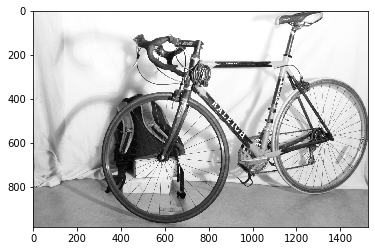

Right Image


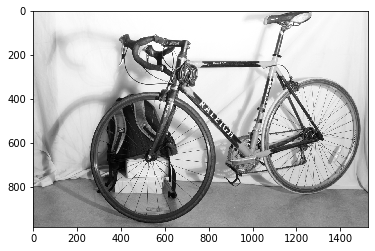

Ground Truth disparity


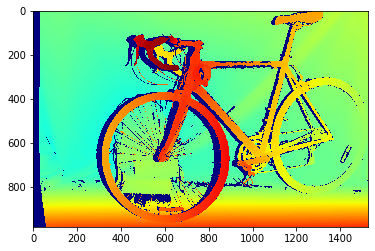

In [31]:
#visualize the data
#pick image for testing
ind_img = 2
print('Left Image')
plt.imshow(X[ind_img][0][0][0][0].cpu().numpy(),cmap="gray")
plt.show()
print('Right Image')
plt.imshow(X[ind_img][0][0][1][0].cpu().numpy(),cmap="gray")
plt.show()
print('Ground Truth disparity')
plt.imshow(dispnoc[ind_img].cpu().numpy(), cmap='jet')
plt.show()

# Network Architecture

In this part, **you** will be implementing **MCNET** network architecture as described in the paper. We will follow the description of the accurate network for Middlebury dataset, see the instruction page for the network diagram. 

In [0]:
from torch import nn
from custom_utils import save_model, load_model

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)
      
      
class MCNET(torch.nn.Module):
    """

    MCNET based on paper from [Zbontar & LeCun, 2015]. This network takes as input two patches of size 11x11 and output the 
    likelihood of the two patches being a match. 

    Args:
    -   ws: window size (or blocking size) of the input patch
    -   batch_size: batch size 
    Returns:
    -   matching cost between the 2 patches, we use 0 for positive match (represent 0 cost to match) and 1 for negative match

    """

    def __init__(self, ws = 11, batch_size=512, load_path = None, strict=True):
        super(MCNET, self).__init__()
        
        num_feature_map = 112 
        kernel_size = 3
        num_hidden_unit = 384
        self.batch_size = batch_size
        self.ws = ws
        self.strict = strict

        self.net = nn.Sequential(
            ############################################################################
            # Student code begin
            ############################################################################
            nn.Conv2d(1, num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),
            nn.Conv2d(num_feature_map, num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),
            nn.Conv2d(num_feature_map, num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),
            nn.Conv2d(num_feature_map, num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),
            nn.Conv2d(num_feature_map, num_feature_map, kernel_size=kernel_size, stride=1, padding=(kernel_size//2)),
            nn.ReLU(),
            Reshape((batch_size,num_feature_map*ws*ws*2)),
            nn.Linear(num_feature_map*ws*ws*2,num_hidden_unit),
            nn.ReLU(),
            nn.Linear(num_hidden_unit,num_hidden_unit),
            nn.ReLU(),
            nn.Linear(num_hidden_unit,1),
            nn.Sigmoid(),
            ############################################################################
            # Student code end
            ############################################################################

        ).to(device)

        self.criterion = nn.BCELoss().to(device)
        if load_path is not None:
          self.net = load_model(self.net,load_path, strict=strict)

    def forward(self, x):
        
        return self.net(x)

In [33]:
######################################################################
#this block will act as a unit test for your MCNET architecture. There are 2 tests here
#1) test that your network output the correct size
#2) test that you can load up a pre-trained network with the correct architecture. 
#Make sure you are able to run it without any error. 
from custom_utils import verify, test_mcnet

net_tr = MCNET(ws=11,batch_size=1)
print('Testing for MCNET:', verify(test_mcnet,net_tr))


Testing for MCNET: "Correct"


In [34]:
######################################################################
#To experiment with different architecture, you can set strict=False which allow for partial loading 
#of the weight parameters, 

#You can also train from scratch by setting load_path to None
#######################################################################

net_tr = MCNET(ws=11,load_path = 'mc_cnn_network_pretrain_ws11.pth',strict=True)

print(net_tr)

MCNET(
  (net): Sequential(
    (0): Conv2d(1, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Reshape()
    (11): Linear(in_features=27104, out_features=384, bias=True)
    (12): ReLU()
    (13): Linear(in_features=384, out_features=384, bias=True)
    (14): ReLU()
    (15): Linear(in_features=384, out_features=1, bias=True)
    (16): Sigmoid()
  )
  (criterion): BCELoss()
)


**Deliverables:** Network architecture implementation in MCNET and copy the output of `print(net_tr)` above to the report.


**Questions**: 
1.   What's the purpose of ReLU and why do we add it after every conv and fc layers?



# Data preparation

In [0]:
def gen_patch(image, x, y, ws = 11):
    """
    function to return a patch of size ws at a specific location of the image.
    x, y in this case is a top left corner of the patch, for example if x,y is (0,0)
    you should return a patch over (0,0) and (ws,ws)
    
    For corner case, you can pad the output with zeros such that we always have 
    (channel, ws, ws) dimension output
    
    Args:
    -   image: image of type Tensor with dimension (channel, width, height)
    -   x: x location in the image 
    -   y: y location in the image
    -   ws: window size or block size of the patch we want
    Returns:
    -   patch: a patch of size (channel, ws, ws) of type Tensor

    """
    ############################################################################
    # Student code begin
    ############################################################################
    x = int(x)
    y = int(y)
    if x < 0:
      x = 0
    if y < 0:
      y = 0
    patch = torch.zeros(image.shape[0],ws,ws)
    w = min(image.shape[1], x + ws) - x
    h = min(image.shape[2], y + ws) - y
    patch[:, 0:w, 0:h] = image[:, x:x+w, y:y+h]

    return patch
    
    
    ############################################################################
    # Student code end
    ############################################################################

In [36]:
######################################################################
#this block will act as a unit test for your gen_patch function. 

from custom_utils import verify, test_gen_patch

print('Testing for gen_patch:', verify(test_gen_patch,gen_patch))


Testing for gen_patch: "Correct"


Here is an example of positive and negative match that we will use to train

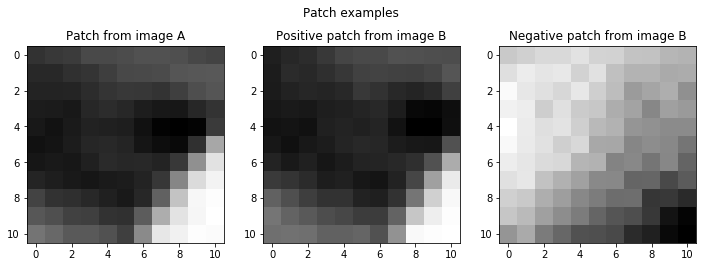

In [37]:
import math
from custom_utils import get_disparity

ind = 423267#np.random.randint(0,len(nnz))

img, dim3, dim4, d = get_disparity(nnz,ind)

d_pos = 0
d_neg = torch.Tensor(1).uniform_(5,25)

if torch.Tensor(1) < 0.5:
    d_neg = -d_neg

x0 = X[int(img)][0][0,0]
x1 = X[int(img)][0][0,1]

anchor = gen_patch(x0, dim3, dim4)
pos = gen_patch(x1, dim3, dim4 - d + d_pos)
neg = gen_patch(x1, dim3, dim4 - d + d_neg)

fig = plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.imshow(anchor[0].cpu().numpy(),cmap='gray')
plt.title('Patch from image A')

plt.subplot(1, 3, 2)
plt.imshow(pos[0].cpu().numpy(),cmap='gray')
plt.title('Positive patch from image B')

plt.subplot(1, 3, 3)
plt.imshow(neg[0].cpu().numpy(),cmap='gray')
plt.title('Negative patch from image B')

fig.suptitle('Patch examples')
plt.show()


**Deliverables:** Implement gen_patch() function and copy the patch example above to the report

**Questions:** 
1.   Giving a true disparity map for each stereo pair, how do we extract positive and negative patches for the training?



# Train

In the following part, the goal is to train a network that learn how to classify 2 patches as positive vs negative match. Your task is to train a best network by experimenting with the learning parameters below. There is no coding required in this part, but you should familiarize yourself with how the training and tuning parameters work.

In [0]:
def run_net(model, nnz, batch_size, ws=11,  max_epoch=1, split='train', optimizer=None, viz_frequency=1, save_frequency=200, fname="mc_cnn_network.pth"):
    epoch = 1
    loss_history = []
    perm = torch.randperm(nnz.size(0))
    for t in range(1,int(len(nnz) - batch_size // 2),batch_size // 2):
        x_batch_tr = torch.zeros(batch_size*2, 1, ws, ws).type(tensor_type).to(device)
        y_batch_tr = torch.zeros(batch_size).type(tensor_type).to(device)
        x_batch_tr_ = torch.zeros(x_batch_tr.size()).to(device)
        y_batch_tr_ = torch.zeros(y_batch_tr.size()).to(device)
        for i in range(1,batch_size//2 + 1):
            d_pos = 0
            d_neg = torch.Tensor(1).uniform_(1.5,18)

            if torch.rand(1) < 0.5:
                d_neg = -d_neg

            ind = perm[t+i-2]
            img, dim3, dim4, d = get_disparity(nnz,ind)
            
            if split=='train':
                if img == ind_img: # Leave out 1 image for validation
                    continue
            elif split=='test':
                if img != ind_img: # Only operate on validation image
                    continue

            if len(X[int(img)]) == 0:
                continue

            x0 = X[int(img)][0][0,0]
            x1 = X[int(img)][0][0,1]

            #normalize image
            x0 = x0.add(-x0.mean()).div(x0.std())
            x1 = x1.add(-x1.mean()).div(x1.std())

            x_batch_tr_[i * 4 - 4] = gen_patch(x0, dim3, dim4, ws=ws)
            x_batch_tr_[i * 4 - 3] = gen_patch(x1, dim3, dim4 - d + d_pos, ws=ws)
            x_batch_tr_[i * 4 - 2] = gen_patch(x0,  dim3, dim4, ws=ws)
            x_batch_tr_[i * 4 - 1] = gen_patch(x1, dim3, dim4 - d + d_neg, ws=ws)

            y_batch_tr_[i*2-2] = 0
            y_batch_tr_[i*2-1] = 1

        x_batch_tr = (x_batch_tr_).clone()
        y_batch_tr = (y_batch_tr_).clone()

        output = model(x_batch_tr)
        loss = model.criterion(output,y_batch_tr.view(batch_size,1))
        if split == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoch == 1 or ((epoch) % save_frequency) == 0:
                save_model(model.net,fname)
                
        if ((epoch) % viz_frequency) == 0:
            print(f'Iteration: {epoch}, Loss: {loss.data}')

        epoch = epoch + 1
        loss_history.append(loss.data.cpu().numpy())
        if epoch > max_epoch: # ge instead of > ?
            break
    return loss_history

Iteration: 5, Loss: 0.4632020890712738
Iteration: 10, Loss: 0.24320296943187714
Iteration: 15, Loss: 0.3102434277534485
Iteration: 20, Loss: 0.23527806997299194
Iteration: 25, Loss: 0.1941932588815689
Iteration: 30, Loss: 0.2229323387145996
Iteration: 35, Loss: 0.17400719225406647
Iteration: 40, Loss: 0.1857665330171585
Iteration: 45, Loss: 0.1797901839017868
Iteration: 50, Loss: 0.19239173829555511
Iteration: 55, Loss: 0.17210541665554047
Iteration: 60, Loss: 0.17056848108768463
Iteration: 65, Loss: 0.16580380499362946
Iteration: 70, Loss: 0.19604609906673431
Iteration: 75, Loss: 0.17189249396324158
Iteration: 80, Loss: 0.1940372884273529
Iteration: 85, Loss: 0.15390701591968536
Iteration: 90, Loss: 0.13760466873645782
Iteration: 95, Loss: 0.162706196308136
Iteration: 100, Loss: 0.17666897177696228
Iteration: 105, Loss: 0.16514094173908234
Iteration: 110, Loss: 0.14631789922714233
Iteration: 115, Loss: 0.15610197186470032
Iteration: 120, Loss: 0.15840759873390198
Iteration: 125, Loss:

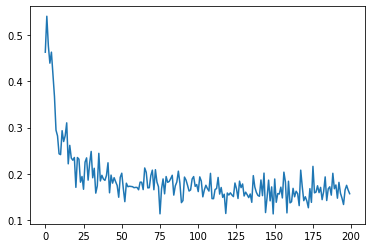

In [39]:
#train
import math
import time
st = time.time()

viz_frequency = 5
save_frequency = 50 #for saving model

############# EXPERIMENT WITH THESE ########

#you can change this to load up pretrain network for other window size
net_tr = MCNET(ws=11,load_path = 'mc_cnn_network_pretrain_ws11.pth',strict=True) 

max_epoch = 200
learning_rate = 0.001

# optimizer = torch.optim.Adam(net_tr.net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net_tr.net.parameters(), lr=learning_rate, momentum=0.9)
############################################

batch_size = net_tr.batch_size
ws = net_tr.ws

loss_history = run_net(model=net_tr,
                       nnz=nnz, 
                       batch_size=batch_size, 
                       ws=ws, 
                       max_epoch=max_epoch, 
                       split='train', 
                       optimizer=optimizer,
                       viz_frequency=viz_frequency, 
                       save_frequency=save_frequency,
                       fname = 'mc_cnn_network_ws11.pth'
                      )

print('Time elasped: ', time.time() - st) 

print('Training Loss')
plt.plot(loss_history)
plt.show()

In [0]:
def evaluate_network(network):

  #compute loss on the held out validation set 
  #nnz_val = nnz#loadbin(f'{data_dir}/mb_valid_disp_coord_val.bin')

  num_test_epochs = 50
  
  batch_size = network.batch_size
  ws = network.ws

  loss_history = run_net(model=network,
                         nnz=nnz, 
                         batch_size=batch_size, 
                         ws=ws, 
                         max_epoch=num_test_epochs, 
                         split='test', 
                         viz_frequency=num_test_epochs+1, 
                         save_frequency=save_frequency)
  
   #validation_loss))
  return np.mean(np.array(loss_history))

In [41]:
net_te = MCNET(ws=11, load_path = 'mc_cnn_network_ws11.pth')
val_loss = evaluate_network(net_te)

print('Final average validation loss:', val_loss)

Final average validation loss: 0.23534787


The network will be saved in `mc_cnn_network_vanilla.pth` or whatever name you set, this is the final saved model you'll need to run other part of the project. You can download a copy of this from colab so that you don't lost progress if anything goes wrong.

**Deliverables:** train the network to achieve the lowest error as possible. Copy the training loss plot and the final validation loss to the report.

**Questions:** 


1.   How does changing learning rate (try using large (> 1) vs small value (< 1e-5)) effect the training? Why do you think that's the case?
2.   What's the difference between Adam and SGD? What do you notice when switching between them?
3.   Is your validation loss lower or higher than your training loss? What is the reason for that? How would we get a better validation loss?




# Modifying the Network for Performance

Here we will experiment with adding layers and varying window size and observe the effect this has on overall performance. 

## Vary window size

In the previous section, we use window size of 11 as suggested in the paper, meaning that the input to the network will be patches of size 11x11. This corresponds to the block size that will be used when perform stereo matching later on.

In this part we would like you to experiment with other window size, namely 5x5, 9x9, and 15x15 and compare the performance. You can set this in the previous cell for training,

**Deliverables:** Training loss curves and validation loss for window sizes of 5, 9, 15 added to the report.


**Questions**: 
1.   What's the effect of varying the window size on performance? Do you suppose there is an optimal window size for all images? Explain why or why not. 


## Vary Network Architecture

Using your favorite window size (note it in the report), we will be varying the architecture slightly to see how this effects training and performance. In `CustomModule` you can add any network architecture that you want. For our purposes, simply add an additional fully-connected layer of the same size for training. We can access the full list of layers of a model using: 

```*list(model.children())``` 

HINT: The final linear layer non-linearity of the original network should be removed, replaced with a ReLU, and added to the end of your new layer! 

In [0]:
class ExtendedNet(torch.nn.Module):
    """
    For adding layers to a previously defined network.
    
    Args:
    -   ws: window size (or blocking size) of the input patch
    -   batch_size: batch size 
    Returns:
    -   matching cost between the 2 patches, we use 0 for positive match (represent 0 cost to match) and 1 for negative match

    """

    def __init__(self, orig_model, ws = 11, batch_size=512, new_layer_size = 384, load_path=None, strict=True):
        super(ExtendedNet, self).__init__()
        
        self.batch_size = batch_size
        self.ws = ws
        self.strict = strict

        self.net = nn.Sequential(
            ############################################################################
            # Student code begin
            ############################################################################

            # *list(MCNET.children(self))[:-1],
            *list(orig_model.children())[0][:-2],
            nn.Linear(new_layer_size,new_layer_size),
            nn.ReLU(),
            nn.Linear(new_layer_size,1),
            nn.Sigmoid(),

            ############################################################################
            # Student code end
            ############################################################################
        ).to(device)
        
        self.criterion = nn.BCELoss().to(device)
        
        if load_path is not None:
            self.net = load_model(self.net,load_path, strict=strict)     


    def forward(self, x):
        
        return self.net(x)
      


In [43]:
######################################################################
#this block will act as a unit test for your extension of the  MCNET architecture. We will load up a pre-trained network of the 
#same architecture. Make sure you are able to run it without any error. 

#To experiment with different architecture, you can set strict=False which allow for partial loading 
#of the weight parameters, 

#You can also train from scratch by setting load_path to None
#######################################################################

######STUDENT CODE HERE##########
ws = 11 #pick your favorite window size (from the pretrained sizes available)
#################################

from custom_utils import verify, test_extendednet


net_tr = MCNET(ws=ws, load_path = f'mc_cnn_network_pretrain_ws{ws}.pth',strict=True)
print(net_tr)

net_extended = ExtendedNet(orig_model=net_tr, ws=ws, batch_size=512, strict=True)
print(net_extended)

print('Testing for MCNET:', verify(test_extendednet,net_extended))


MCNET(
  (net): Sequential(
    (0): Conv2d(1, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Reshape()
    (11): Linear(in_features=27104, out_features=384, bias=True)
    (12): ReLU()
    (13): Linear(in_features=384, out_features=384, bias=True)
    (14): ReLU()
    (15): Linear(in_features=384, out_features=1, bias=True)
    (16): Sigmoid()
  )
  (criterion): BCELoss()
)
ExtendedNet(
  (net): Sequential(
    (0): Conv2d(1, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU

Iteration: 5, Loss: 0.6789436936378479
Iteration: 10, Loss: 0.5944816470146179
Iteration: 15, Loss: 0.46320390701293945
Iteration: 20, Loss: 0.3099682629108429
Iteration: 25, Loss: 0.20230475068092346
Iteration: 30, Loss: 0.19848205149173737
Iteration: 35, Loss: 0.20379258692264557
Iteration: 40, Loss: 0.13525298237800598
Iteration: 45, Loss: 0.18306919932365417
Iteration: 50, Loss: 0.17056278884410858
Iteration: 55, Loss: 0.19057223200798035
Iteration: 60, Loss: 0.1833076924085617
Iteration: 65, Loss: 0.15375010669231415
Iteration: 70, Loss: 0.16263511776924133
Iteration: 75, Loss: 0.13479302823543549
Iteration: 80, Loss: 0.1411343812942505
Iteration: 85, Loss: 0.13833653926849365
Iteration: 90, Loss: 0.1416659653186798
Iteration: 95, Loss: 0.16543495655059814
Iteration: 100, Loss: 0.1576797068119049
Iteration: 105, Loss: 0.13199850916862488
Iteration: 110, Loss: 0.1818549633026123
Iteration: 115, Loss: 0.09563641250133514
Iteration: 120, Loss: 0.17534880340099335
Iteration: 125, Loss

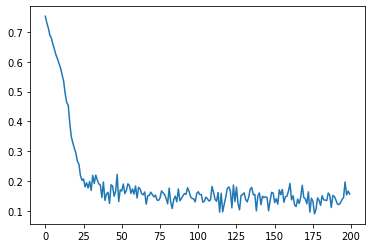

In [44]:
st = time.time()

viz_frequency = 5
save_frequency = 200 #for saving model

max_epoch = 200
learning_rate = 0.0001

optimizer = torch.optim.Adam(net_extended.net.parameters(), lr=learning_rate)

batch_size = net_extended.batch_size
ws = net_extended.ws

loss_history = run_net(model=net_extended,
                       nnz=nnz, 
                       batch_size=batch_size, 
                       ws=ws, 
                       max_epoch=max_epoch, 
                       split='train', 
                       optimizer=optimizer,
                       viz_frequency=viz_frequency, 
                       save_frequency=save_frequency,
                       fname='mc_cnn_network_extend.pth'
                      )

print('Time elasped: ', time.time() - st) 

print('Training Loss')
plt.plot(loss_history)
plt.show()

In [45]:
#compute loss on the held out validation set 

net_te = MCNET(ws=ws)
net_extended = ExtendedNet(orig_model=net_te, ws=ws, batch_size=512, load_path='mc_cnn_network_extend.pth', strict=True)

# orig_model, ws = 11, batch_size=512, new_layer_size = 384, load_path=None, strict=True

batch_size = net_extended.batch_size
ws = net_extended.ws

val_loss = evaluate_network(net_extended)

print('Final average validation loss:', val_loss) #validation_loss))

Final average validation loss: 0.27806985


**Deliverables:** New network architecture that extends MCNET, the loss curve from training it, and the validation accuracy of the new network. Copy the output of `print(net_extended)`, the training loss, and the final mean validation loss to the report.


**Questions**: 
1.   What's the effect of adding more layers without adding more data?



# Evaluate stereo matching

For this part we will again generate the disparity map but this time from our newly trained matching cost network instead of SAD/SSD. You should first **upload 2 files from part 1 (similarity_measures.py, disparity_map.py)** into colab environment. Click at the `>` sign on the top left, choose `Files` tab, then upload the 2 files into the current directory.

Note that all the required functions in part 1 need to be implemented correctly before starting this part. Use this part to evaluate your trained network as a stereo matching cost.  

Hint: You don't have to re-train the network every time you want to evaluate, as long as your saved model is in Colab file system. Don't forget to change `load_path` to your best model,

In [0]:
###########Change to your best model here################

net_te = MCNET(batch_size = 1, load_path = 'mc_cnn_network_ws11.pth')

#net_extended = ExtendedNet(orig_model=net_te, ws=ws, batch_size=512, load_path='mc_cnn_network_extend.pth', strict=True)

############################################

In [0]:
try:
  from similarity_measures import sad_similarity_measure,ssd_similarity_measure
  from disparity_map import calculate_disparity_map
except ModuleNotFoundError:
  print('\033[91m Error: please upload disparity_map.py and similarity_measures.py from part 1\033[0m ')
from custom_utils import loadbin, DataLoader
import numpy as np
import os
import time

#loading images from our testing set

try:
  assert len(X) is not None #dummy code to check if X exists
except NameError:
  #load up data again in case we start from this part
  data_dir = 'subtest_bin/'

  nnz_te = loadbin(f'{data_dir}/mb_valid_disp_coord.bin')
  nnz = nnz_te

  X, dispnoc = DataLoader(nnz_te, data_dir)
  ind_img = 2
    
scale = 5
im_left = X[ind_img][0][0][0][0][::scale,::scale]
im_right = X[ind_img][0][0][1][0][::scale,::scale]
im_dispnoc = dispnoc[ind_img][::scale,::scale]
im_dispnoc_full = dispnoc[ind_img]

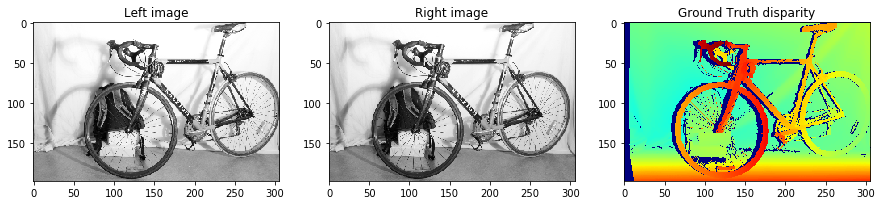

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(5*3)

ax1.imshow(im_left.cpu().numpy(), cmap="gray")
ax1.title.set_text('Left image')

ax2.imshow(im_right.cpu().numpy(), cmap="gray")
ax2.title.set_text('Right image')

ax3.imshow(im_dispnoc.cpu().numpy(), cmap="jet")
ax3.title.set_text('Ground Truth disparity')

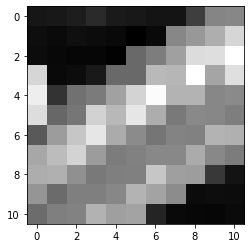

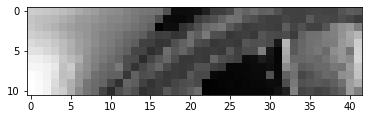

In [0]:
# extract a patch of interest from the left image
patch_left_img = im_left[80:91, 85:96]

# get the search area in the right image
search_area_right_img = (im_right[80:91, 60:102])

plt.imshow(patch_left_img.cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(search_area_right_img.cpu().numpy(),cmap='gray')
plt.show()


In [0]:
def cnn_similarity_measure(patch1, patch2, ws=11):
    """

    """
    assert patch1.shape==patch2.shape

    if isinstance(patch1,np.ndarray) or isinstance(patch2,np.ndarray):
      patch1 = torch.tensor(patch1)
      patch2 = torch.tensor(patch2)
      
    patch1 = patch1.unsqueeze(0).unsqueeze(0)
    patch2 = patch2.unsqueeze(0).unsqueeze(0)
    patch1 = patch1.add(-patch1.mean()).div(patch1.std()).reshape(1,1,ws,ws)
    patch2 = patch2.add(-patch2.mean()).div(patch2.std()).reshape(1,1,ws,ws)


    x = torch.cat((patch1,patch2),0)[:,:,:,:]
    output = net_te(x.to(device))[0][0]
    return output

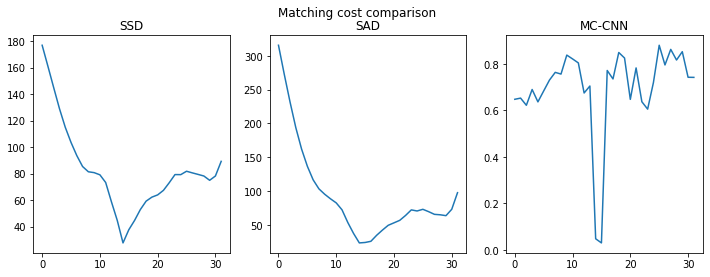

In [0]:
fig = plt.figure(figsize=(12,4))

similarity_vals = np.array([sad_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:(h_idx+11)]) for h_idx in range(search_area_right_img.shape[1]-10)])
plt.subplot(1, 3, 1)
plt.plot(similarity_vals)
plt.title('SSD')

similarity_vals = np.array([ssd_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:(h_idx+11)]) for h_idx in range(search_area_right_img.shape[1]-10)])
plt.subplot(1, 3, 2)
plt.plot(similarity_vals)
plt.title('SAD')

similarity_vals = np.array([cnn_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:(h_idx+11)]) for h_idx in range(search_area_right_img.shape[1]-10)])
plt.subplot(1, 3, 3)
plt.plot(similarity_vals)
plt.title('MC-CNN')
fig.suptitle('Matching cost comparison')
plt.show()

**Deliverables:** copy the matching cost comparison to the report

**Questions:**


1.   Based on the matching cost comparison plot, how are SSD, SAD, and MC-CNN different? Can you think of a scenario where matching with MC-CNN would be prefered over SSD/SAD?



The following cell can take around **an hour** to run, we suggest you only run this at the end when you are confident in the network you trained and want to evaluate the results. (HINT: your validation loss should be lower than 0.3 before you proceed.)

In [0]:
# calculate the disparity map with block size of 11 this will take awhile
st = time.time()
disp_map = calculate_disparity_map((im_left.unsqueeze(0).transpose(2,0).transpose(0,1)), #swap the channel
                                   (im_right.unsqueeze(0).transpose(2,0).transpose(0,1)), 
                                   block_size=11, 
                                   sim_measure_function = sad_similarity_measure,
                                   max_search_bound = 30)

disp_map_cnn = calculate_disparity_map(im_left.unsqueeze(0).transpose(2,0).transpose(0,1), 
                                   im_right.unsqueeze(0).transpose(2,0).transpose(0,1), 
                                   block_size=11, 
                                   sim_measure_function = cnn_similarity_measure,
                                   max_search_bound = 30)
print('Time Elasped:', time.time() - st)

Time Elasped: 3813.7284350395203


In [0]:
from cv2 import resize
def evaluate_stereo(gt, disp):
  
  max_disp = 280
  mask = gt!=np.inf

  if disp.shape != gt.shape:
    ratio = float(gt.shape[1])/disp.shape[1]
    disp=resize(disp,(gt.shape[0],gt.shape[1])).transpose()*ratio
  disp[disp>max_disp]=max_disp
  
  errmap = np.abs(gt-disp)*mask
  avgerr = errmap[mask].mean()
  bad1map = (errmap>1) * mask
  bad1 = bad1map[mask].sum()/float(mask.sum())*100 #percentage of bad pixels whose error is greater than 1

  bad2map = (errmap>2) * mask
  bad2 = bad2map[mask].sum()/float(mask.sum())*100

  bad4map = (errmap>4) * mask
  bad4 = bad4map[mask].sum()/float(mask.sum())*100
  
  return avgerr, bad1, bad2, bad4

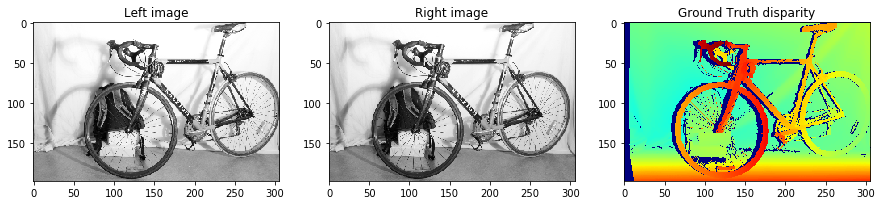

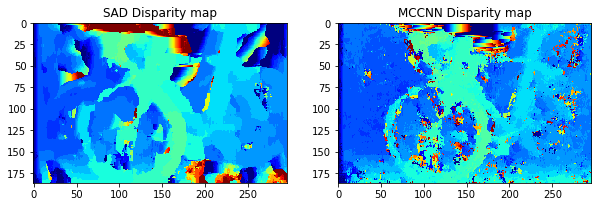

--------------------------------------------------------------------------
Metrics: 		 SAD 			 MCCNN
--------------------------------------------------------------------------
Average Error 		 23.70199 		 19.873316
%error > 1 pixel	 95.35363988960991 	 93.96850259459345
%error > 2 pixels	 90.88056345832135 	 88.01052754957432
%error > 4 pixels	 81.29468614476446 	 77.76821010346407


In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(5*3)

ax1.imshow(im_left.cpu().numpy(), cmap="gray")
ax1.title.set_text('Left image')

ax2.imshow(im_right.cpu().numpy(), cmap="gray")
ax2.title.set_text('Right image')

ratio = float(im_dispnoc_full.shape[1])/disp_map.shape[1] #ratio for the actual disparity in pixel

ax3.imshow(im_dispnoc.cpu().numpy()/ratio, cmap="jet", interpolation='nearest')
ax3.title.set_text('Ground Truth disparity')
fig, (ax4, ax5) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(5*2)

ax4.imshow((disp_map.cpu().numpy()), cmap='jet', interpolation='nearest')
ax4.title.set_text('SAD Disparity map')

ax5.imshow((disp_map_cnn.cpu().numpy().astype(np.float32)), cmap='jet', interpolation='nearest')
ax5.title.set_text('MCCNN Disparity map')

plt.show()

cnn_avgerr, cnn_bad1, cnn_bad2, cnn_bad4 = evaluate_stereo(im_dispnoc_full.cpu().numpy(),disp_map_cnn.cpu().numpy().astype(np.float32))
sad_avgerr,  sad_bad1, sad_bad2, sad_bad4 = evaluate_stereo(im_dispnoc_full.cpu().numpy(),disp_map.cpu().numpy().astype(np.float32))


print('--------------------------------------------------------------------------')
print('Metrics: \t\t', 'SAD','\t\t\t','MCCNN')
print('--------------------------------------------------------------------------')
print('Average Error \t\t',sad_avgerr,'\t\t', cnn_avgerr)
print('%error > 1 pixel\t', sad_bad1,'\t',cnn_bad1)
print('%error > 2 pixels\t',sad_bad2, '\t',cnn_bad2)
print('%error > 4 pixels\t',sad_bad4, '\t', cnn_bad4)

**Deliverables:** Make a screen shot of the disparity map and the evaluation results above and copy them to the report.

**Questions:**


1.   Qualitatively, between SAD and MCCNN, which disparity map do you think looks better? Explain your reasoning.
2.   Quantitatively, between SAD and MCCNN, which one acieve better score on the metrics? Why do you think that's the case?

